In [1]:
# Import library-library yang diperlukan
import cv2  # Untuk pemrosesan gambar
import mediapipe as mp  # Untuk deteksi landmark telapak tangan
import numpy as np  # Untuk operasi matematika
import matplotlib.pyplot as plt  # Untuk visualisasi
import os  # Untuk operasi file dan direktori
import tensorflow as tf
from scipy.spatial.distance import cosine
from glob import glob

## Tahap 1: Load dan Tampilkan Gambar Asli
### Pada tahap ini, kita akan:
### 1. Membaca file gambar menggunakan OpenCV
### 2. Mengubah format warna dari BGR ke RGB (OpenCV membaca dalam format BGR)
### 3. Menampilkan gambar asli untuk memastikan loading berhasil

In [3]:
def load_and_display_image(image_path):
    """
    Fungsi untuk membaca dan menampilkan gambar asli

    Parameters:
    image_path (str): Path ke file gambar

    Returns:
    array: Gambar dalam format RGB
    """
    # Baca gambar dengan OpenCV
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Tidak dapat membaca gambar: {image_path}")

    # Convert BGR ke RGB karena OpenCV membaca dalam format BGR
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tampilkan gambar
    plt.figure(figsize=(8,8))
    plt.imshow(image_rgb)
    plt.title('Gambar Asli')
    plt.axis('off')
    plt.show()

    return image_rgb

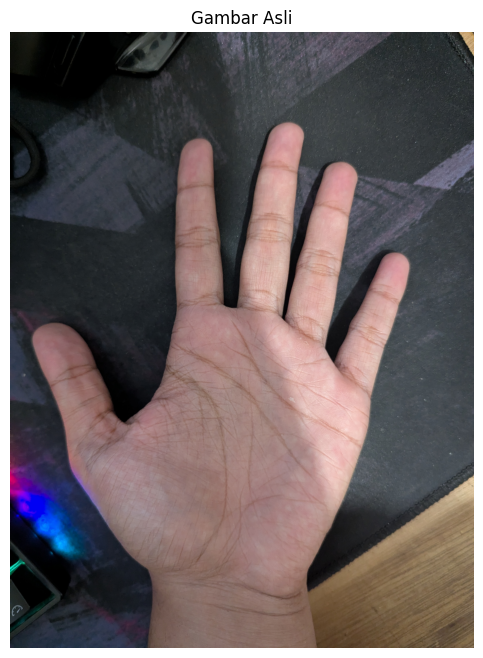

Ukuran gambar asli: (4080, 3072, 3)


In [26]:
image_path = "/CAPSTONE-PROJECT/data/raw/DATASET-002.jpg"
original_image = load_and_display_image(image_path)
print(f"Ukuran gambar asli: {original_image.shape}")

## Tahap 2: Deteksi Landmark Telapak Tangan
### Pada tahap ini, kita akan:
### 1. Menginisialisasi MediaPipe Hands untuk deteksi landmark
### 2. Mendeteksi 21 titik landmark pada telapak tangan
### 3. Memvisualisasikan landmark yang terdeteksi

### MediaPipe akan mendeteksi 21 titik pada tangan, termasuk:
### - Titik-titik pada setiap jari
### - Titik-titik pada telapak tangan
### - Koneksi antar titik

In [6]:
def detect_hand_landmarks(image_rgb):
    """
    Fungsi untuk mendeteksi landmark telapak tangan

    Parameters:
    image_rgb (array): Gambar dalam format RGB

    Returns:
    object: Objek landmark MediaPipe atau None jika tidak terdeteksi
    """
    # Inisialisasi MediaPipe Hands
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils

    hands = mp_hands.Hands(
        static_image_mode=True,  # Mode gambar statis (bukan video)
        max_num_hands=1,         # Maksimal 1 tangan yang dideteksi
        min_detection_confidence=0.5  # Threshold confidence untuk deteksi
    )

    # Proses gambar untuk deteksi landmark
    results = hands.process(image_rgb)

    # Visualisasi landmark jika terdeteksi
    image_with_landmarks = image_rgb.copy()
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Gambar landmark dan koneksinya
            mp_drawing.draw_landmarks(
                image_with_landmarks,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS)

        plt.figure(figsize=(8,8))
        plt.imshow(image_with_landmarks)
        plt.axis('off')
        plt.show()

        return results.multi_hand_landmarks[0]
    else:
        print("Tidak ada landmark tangan yang terdeteksi!")
        return None

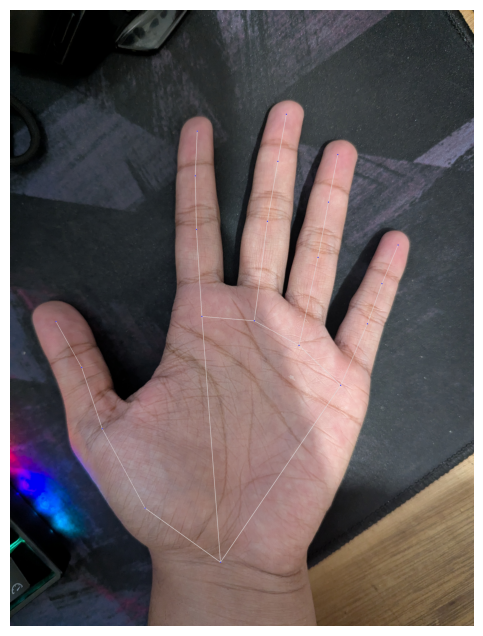

In [27]:
hand_landmarks = detect_hand_landmarks(original_image)

In [21]:
def extract_palm_roi(image_rgb, hand_landmarks):
    """
    Fungsi untuk mengekstrak ROI telapak tangan

    Parameters:
    image_rgb (array): Gambar dalam format RGB
    hand_landmarks (object): Objek landmark MediaPipe

    Returns:
    tuple: (ROI gambar, koordinat ROI (x1,y1,x2,y2))
    """
    if hand_landmarks is None:
        return None, None

    h, w, _ = image_rgb.shape

    # Ambil landmark pusat telapak tangan
    # Indeks 1,5,9,13,17 adalah titik-titik pada pangkal setiap jari
    palm_center_indices = [1, 5, 9, 13, 17]
    palm_points = []

    for idx in palm_center_indices:
        landmark = hand_landmarks.landmark[idx]
        # Konversi koordinat relatif ke absolut
        x, y = int(landmark.x * w), int(landmark.y * h)
        palm_points.append((x, y))

    # Hitung pusat telapak tangan
    # Tambah offset 100 pixel ke bawah untuk mencakup area telapak
    center_x = int(np.mean([p[0] for p in palm_points]))
    center_y = int(np.mean([p[1] for p in palm_points])) + 100

    # Hitung ukuran ROI berdasarkan ukuran telapak
    palm_width = max([p[0] for p in palm_points]) - min([p[0] for p in palm_points])
    palm_height = max([p[1] for p in palm_points]) - min([p[1] for p in palm_points])
    roi_size = int(max(palm_width, palm_height) * 0.8)  # 80% dari ukuran maksimal

    # Hitung koordinat ROI
    x1 = max(0, center_x - roi_size//2)  # Pastikan tidak keluar batas kiri
    y1 = max(0, center_y - roi_size//2)  # Pastikan tidak keluar batas atas
    x2 = min(w, x1 + roi_size)  # Pastikan tidak keluar batas kanan
    y2 = min(h, y1 + roi_size)  # Pastikan tidak keluar batas bawah

    # Pastikan ROI berbentuk persegi
    roi_size = min(x2-x1, y2-y1)
    x2 = x1 + roi_size
    y2 = y1 + roi_size

    # Ekstrak ROI
    roi = image_rgb[y1:y2, x1:x2]

    # Visualisasi
    img_with_roi = image_rgb.copy()
    cv2.rectangle(img_with_roi, (x1,y1), (x2,y2), (0,255,0), 2)

    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(img_with_roi)
    plt.title('Telapak Tangan dengan Kotak ROI')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(roi)
    plt.title(f'ROI Terekstrak {roi.shape[:2]}')
    plt.axis('off')
    plt.show()

    return roi, (x1,y1,x2,y2)

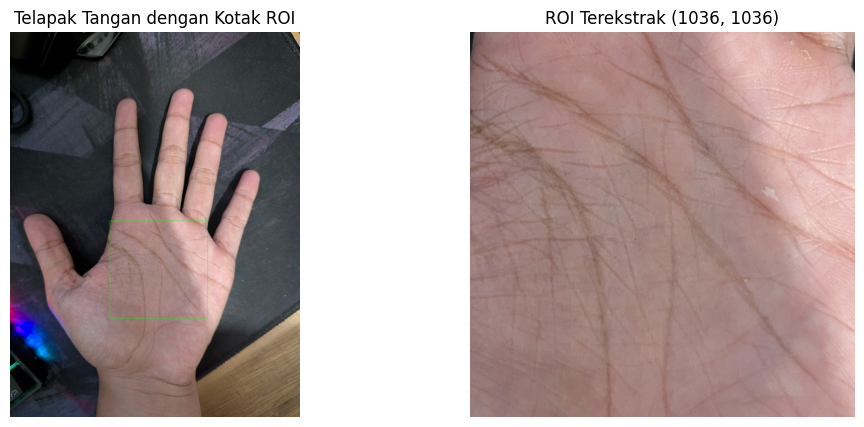

Koordinat ROI: (1058, 2000, 2094, 3036)
Ukuran ROI: (1036, 1036, 3)


In [28]:
roi, coords = extract_palm_roi(original_image, hand_landmarks)
print(f"Koordinat ROI: {coords}")
print(f"Ukuran ROI: {roi.shape if roi is not None else 'None'}")

## Tahap 4: Konversi ke Grayscale
### Pada tahap ini, kita akan:
### 1. Mengkonversi gambar ROI dari RGB ke grayscale
### 2. Grayscale mengurangi kompleksitas dan memudahkan tahap preprocessing selanjutnya
### 3. Menyimpan informasi intensitas yang penting untuk analisis telapak tangan

In [11]:
def convert_to_grayscale(roi):
    """
    Fungsi untuk mengkonversi ROI ke grayscale dan menghilangkan bayangan
    dengan pemrosesan tambahan untuk hasil yang lebih optimal
    
    Keterangan:
    roi (array): Gambar ROI dalam format RGB
    alpha (float): Nilai kontras (range: 0.5-3.0)
    beta (int): Nilai brightness (range: -100 sampai 100)
    clip_limit (float): Batas kontras untuk CLAHE (range: 1.0-5.0)
    gamma (float): Nilai koreksi gamma (range: 0.5-2.0)
    dilate_kernel (int): Ukuran kernel dilasi (range: 3-21, harus ganjil)
    blur_kernel (int): Ukuran kernel blur (range: 3-31, harus ganjil)
    norm_min (int): Batas bawah normalisasi (range: 0-127)
    norm_max (int): Batas atas normalisasi (range: 128-255)
    
    Returns:
    array: Gambar ROI dalam format grayscale tanpa bayangan
    """
    if roi is None:
        return None
        
    # Konversi ke grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    # Langkah 1: Pra-pemrosesan untuk meningkatkan kontras
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Langkah 2: Penghilangan bayangan dengan kernel yang lebih besar
    # Menggunakan kernel dilasi yang lebih besar untuk mencakup area bayangan yang lebih luas
    dilated = cv2.dilate(gray, np.ones((5,5), np.uint8))
    
    # Menggunakan median blur dengan kernel yang lebih besar
    bg_img = cv2.medianBlur(dilated, 25)
    
    # Langkah 3: Penghilangan bayangan
    diff_img = 255 - cv2.absdiff(gray, bg_img)
    
    # Langkah 4: Peningkatan kontras hasil
    # Aplikasikan CLAHE lagi untuk meningkatkan kontras
    diff_img = clahe.apply(diff_img)
    
    # Langkah 5: Normalisasi dengan rentang yang lebih lebar
    normalized = cv2.normalize(diff_img, None, alpha=10, beta=245, 
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # Langkah 6: Final adjustment dengan gamma correction
    gamma = 0.8 
    normalized = np.array(255 * (normalized / 255) ** gamma, dtype='uint8')
    
    # Tampilkan hasil
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(roi)
    plt.title('ROI Original (RGB)')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(gray, cmap='gray')
    plt.title('ROI Grayscale')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(normalized, cmap='gray')
    plt.title('Grayscale Tanpa Bayangan')
    plt.axis('off')
    
    plt.show()
    
    return normalized

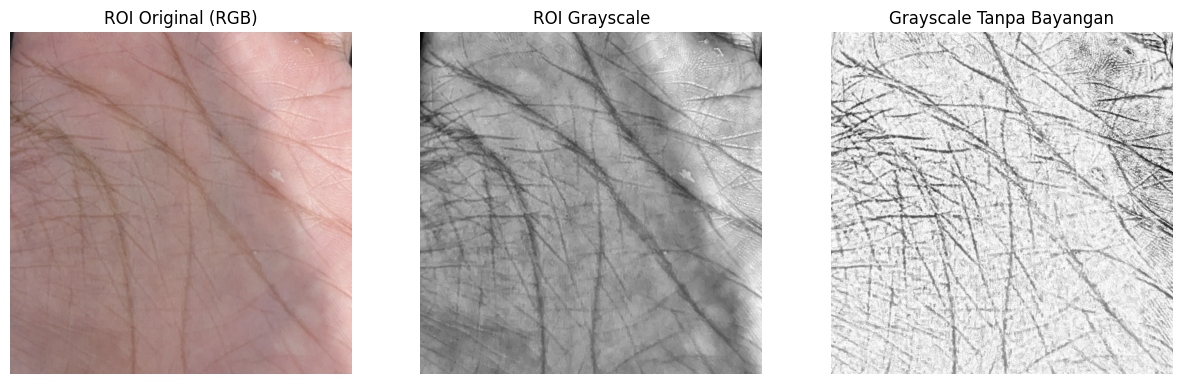

In [29]:
gray_roi = convert_to_grayscale(roi)

## Tahap 6: Resize ke Ukuran Standard
### Pada tahap ini, kita akan:
### 1. Mengubah ukuran gambar ke dimensi standard (128x128)
### 2. Ukuran standard memudahkan pemrosesan selanjutnya
### 3. Memastikan semua gambar memiliki ukuran yang sama
### 4. Mengurangi beban komputasi untuk proses selanjutnya

In [13]:
def resize_roi(enhanced_roi, target_size=(128, 128)):
    """
    Fungsi untuk mengubah ukuran ROI ke dimensi standard

    Parameters:
    enhanced_roi (array): Gambar ROI yang sudah ditingkatkan kontrasnya
    target_size (tuple): Ukuran target (width, height)

    Returns:
    array: Gambar ROI dengan ukuran standard
    """
    if enhanced_roi is None:
        return None

    # Resize gambar
    # INTER_AREA memberikan hasil terbaik untuk pengecilan gambar
    resized = cv2.resize(enhanced_roi, target_size, interpolation=cv2.INTER_AREA)

    # Tampilkan hasil
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(enhanced_roi, cmap='gray')
    plt.title(f'ROI Enhanced {enhanced_roi.shape}')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(resized, cmap='gray')
    plt.title(f'ROI Resized {resized.shape}')
    plt.axis('off')
    plt.show()

    return resized

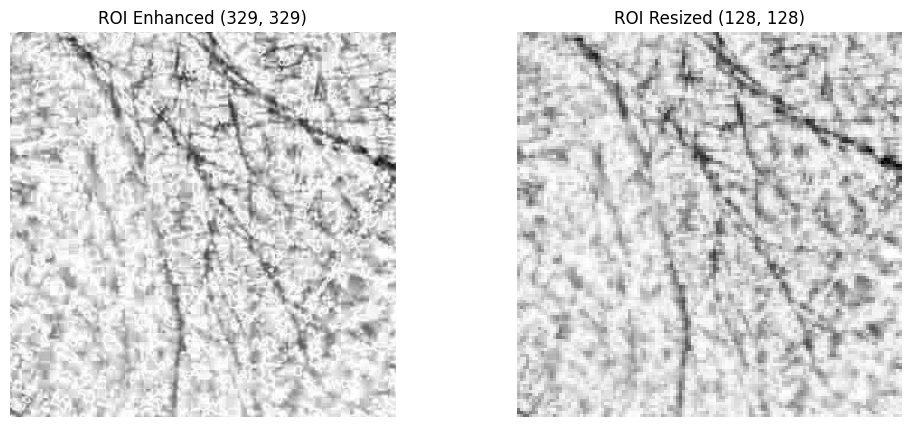

In [14]:
final_roi = resize_roi(gray_roi)

In [15]:
def augment_roi(image):
    """
    Fungsi untuk melakukan augmentasi pada gambar telapak tangan
    dengan rotasi kecil, scaling, dan intensity adjustments
    """
    augmented = {}
    height, width = image.shape
    
    # Simpan gambar original
    augmented['original'] = image
    
    # 1. Rotasi dengan sudut kecil (±10°)
    angles = [-10, 10]
    for angle in angles:
        M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
        rotated = cv2.warpAffine(image, M, (width, height),
                                borderMode=cv2.BORDER_REFLECT)
        augmented[f'rotate_{angle}°'] = rotated
    
    # 2. Scaling up (1.1)
    scale = 1.1
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    scaled = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    # Crop to original size
    start_y = (scaled.shape[0] - height) // 2
    start_x = (scaled.shape[1] - width) // 2
    scaled = scaled[start_y:start_y+height, start_x:start_x+width]
    
    augmented['scale_1.1'] = scaled
    
    # 3. Brightness adjustment (±10%)
    brightnesses = [-25, 25]
    for beta in brightnesses:
        label = 'darker' if beta < 0 else 'brighter'
        adjusted = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
        augmented[f'{label}_10%'] = adjusted
    
    # 4. Contrast adjustment (±10%)
    contrasts = [0.9, 1.1]
    for alpha in contrasts:
        label = 'lower' if alpha < 1 else 'higher'
        adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
        augmented[f'contrast_{label}_10%'] = adjusted
    
    # Tampilkan hasil
    plt.figure(figsize=(15, 10))
    total_imgs = len(augmented)
    cols = 3
    rows = (total_imgs + cols) // cols
    
    for idx, (aug_type, aug_image) in enumerate(augmented.items(), 1):
        plt.subplot(rows, cols, idx)
        plt.imshow(aug_image, cmap='gray')
        plt.title(f'Augmentation:\n{aug_type}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal augmented images generated: {len(augmented)}")
    for idx, aug_type in enumerate(augmented.keys(), 1):
        print(f"{idx}. {aug_type}")
    
    return augmented

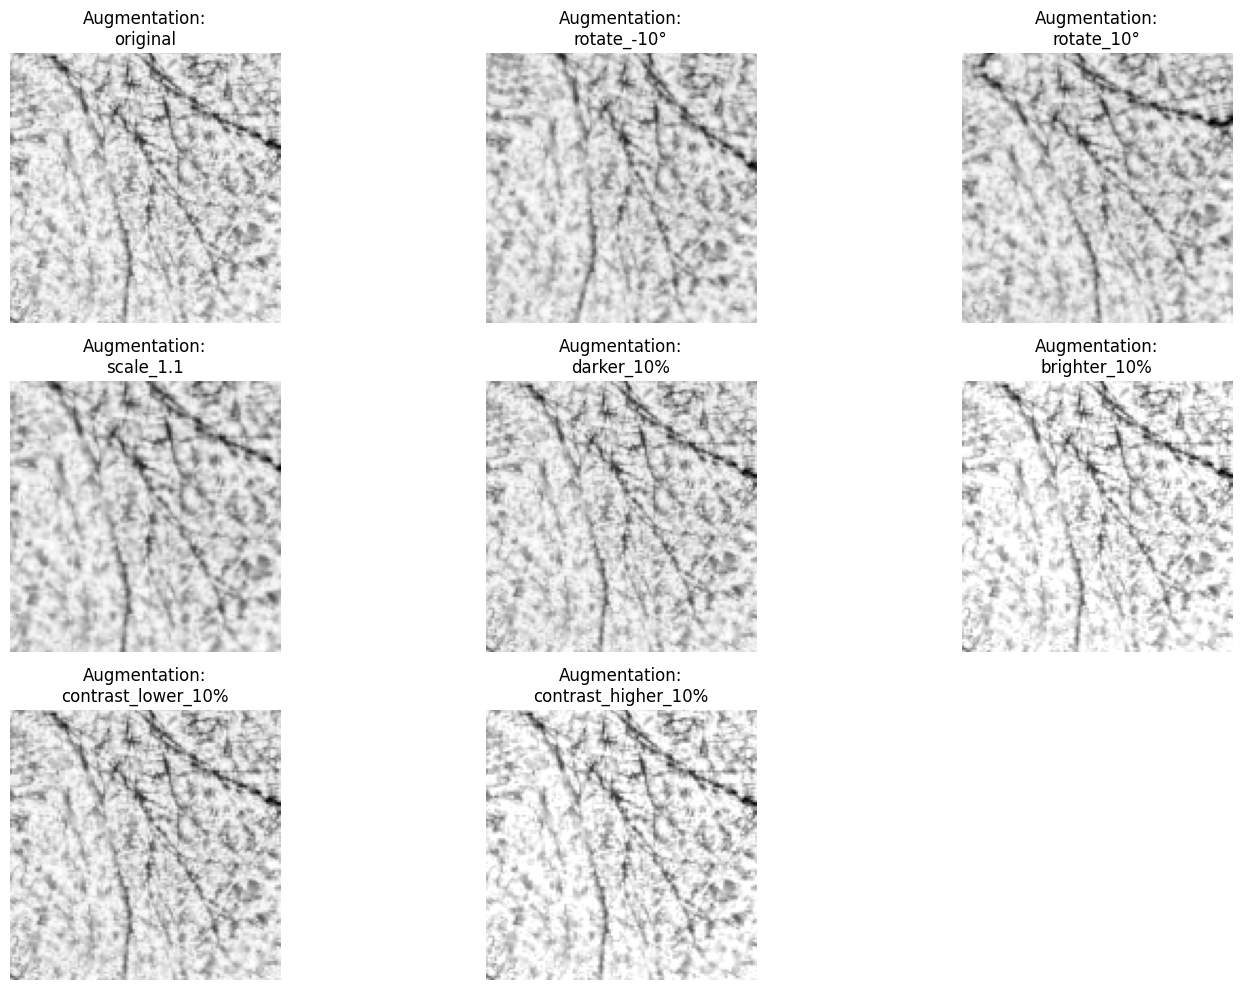


Total augmented images generated: 8
1. original
2. rotate_-10°
3. rotate_10°
4. scale_1.1
5. darker_10%
6. brighter_10%
7. contrast_lower_10%
8. contrast_higher_10%


In [16]:
augmented_images = augment_roi(final_roi)

In [17]:
def save_augmented_images(augmented_dict, base_dir='/CAPSTONE-PROJECT/data'):
    """
    Menyimpan hasil augmentasi dengan person_id otomatis
    """
    # Buat direktori data/temp jika belum ada
    temp_dir = os.path.join(base_dir, 'aug')
    os.makedirs(temp_dir, exist_ok=True)
    
    # Cari person_id berikutnya
    existing_folders = glob(os.path.join(temp_dir, 'person_*'))
    person_id = f"{(len(existing_folders) + 1):03d}"
    
    # Buat dan simpan di folder baru
    save_dir = os.path.join(temp_dir, f'person_{person_id}')
    os.makedirs(save_dir, exist_ok=True)
    
    # Simpan setiap hasil augmentasi
    for idx, (_, image) in enumerate(augmented_dict.items(), 1):
        filename = f'data_{person_id}_{idx}.jpg'
        cv2.imwrite(os.path.join(save_dir, filename), image)
        print(f"Saved: {filename}")
    
    print(f"\nSaved {len(augmented_dict)} images in: person_{person_id}")
    return person_id

In [18]:
person_id = save_augmented_images(augmented_images)

Saved: data_001_1.jpg
Saved: data_001_2.jpg
Saved: data_001_3.jpg
Saved: data_001_4.jpg
Saved: data_001_5.jpg
Saved: data_001_6.jpg
Saved: data_001_7.jpg
Saved: data_001_8.jpg

Saved 8 images in: person_001


## Tahap 7: Simpan Hasil
### Pada tahap ini, kita akan:
### 1. Membuat direktori output jika belum ada
### 2. Menyimpan hasil preprocessing dalam format jpg
### 3. Memastikan penyimpanan berhasil

In [123]:
def save_processed_image(final_roi):
    """
    Fungsi untuk menyimpan hasil preprocessing ke folder temp
    dengan nama file increment

    Parameters:
    final_roi (array): Gambar ROI final

    Returns:
    str: Path lengkap file yang disimpan atau None jika gagal
    """
    if final_roi is None:
        print("Tidak ada gambar untuk disimpan")
        return None

    # Buat direktori temp jika belum ada
    output_dir = "/CAPSTONE-PROJECT/data/temp/"
    os.makedirs(output_dir, exist_ok=True)

    # Hitung jumlah file yang sudah ada untuk increment
    existing_files = len([f for f in os.listdir(output_dir) if f.endswith('.jpg')])

    # Generate filename: palm_001.jpg, palm_002.jpg, dst
    filename = f"palm_{(existing_files + 1):03d}.jpg"

    # Buat path lengkap
    output_path = os.path.join(output_dir, filename)

    # Simpan gambar
    success = cv2.imwrite(output_path, final_roi)

    if success:
        print(f"Berhasil menyimpan gambar ke: {output_path}")
        return output_path
    else:
        print("Gagal menyimpan gambar")
        return None


In [124]:
result = save_processed_image(final_roi)

Berhasil menyimpan gambar ke: /CAPSTONE-PROJECT/data/temp/palm_004.jpg
